In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import math

# TEST ASSUMPTIONS
import statsmodels.stats.api as sms # homoskedasticity
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white # homoskedasticity
from scipy.stats import bartlett # homoskedasticity
from scipy.stats import normaltest # for normal distribution
from statsmodels.stats import diagnostic as diag # autocorellation (not so important)
import statsmodels.api as sm # autocorellation (not so important)

# LASSO model selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso

# CREATED FUNCTIONS
from ufc_func import *

# OUTLIERS
from scipy import stats

In [2]:
df = pd.read_csv("./ufc.csv")
df = pd.DataFrame(df)
df

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith
7413,"Denver, Colorado, USA",Frank Hamaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Morris
7414,"Denver, Colorado, USA",Johnny Rhodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7415,"Denver, Colorado, USA",Patrick Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our dataframe contains some null rows, so will need to remove it. Additionally column with "Time" doesn't useful for our aims in this represantation. We need to convert it to another units (to seconds).

In [3]:
df = df.dropna()
df_with_time = df.copy()

df_with_time["Seconds"] = df_with_time["Time"].apply(time_converter) + df_with_time["Round"].apply(round_converter)
df_with_time


,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0


Also some there are some "strange" fights: fighter 1 and fighter 2 both loss in fight.

In [4]:
df_with_time.tail(10)

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
7403,"Denver, Colorado, USA",Royce Gracie,Fred Ettish,1.0,0.0,13.0,4.0,0.0,0.0,1.0,0.0,Open Weight,SUB Bulldog Choke,1.0,3:07,UFC 2,11-Mar-94,Remco Pardoel,187.0
7404,"Denver, Colorado, USA",Patrick Smith,Scott Morris,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,Open Weight,KO/TKO Elbows,1.0,0:30,UFC 2,11-Mar-94,Johnny Rhodes,30.0
7405,"Denver, Colorado, USA",Royce Gracie,Minoki Ichihara,0.0,0.0,2.0,3.0,1.0,0.0,2.0,0.0,Open Weight,SUB Armbar,1.0,5:08,UFC 2,11-Mar-94,Patrick Smith,308.0
7406,"Denver, Colorado, USA",Remco Pardoel,Scott Baker,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0,Open Weight,SUB Triangle Choke,1.0,6:41,UFC 2,11-Mar-94,Royce Gracie,401.0
7407,"Denver, Colorado, USA",Johnny Rhodes,Alberta Cerra Leon,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,Open Weight,SUB Ezekiel Choke,1.0,9:51,UFC 2,11-Mar-94,Jason DeLucia,591.0
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith,20.0


We need to remove it

In [5]:
df_with_time = df_with_time.loc[
    (df_with_time["Fighter 1"] == df_with_time["Winner"]) | 
    (df_with_time["Fighter 1"] == df_with_time["Winner"])].reset_index(drop=True)

Next, let us show average statistic per fight (including first and second fighter)

In [6]:
total_kd = (df["Fighter_1_KD"] + df["Fighter_2_KD"]).mean()
total_str= (df["Fighter_1_STR"] + df["Fighter_2_STR"]).mean()
total_td= (df["Fighter_1_TD"] + df["Fighter_2_TD"]).mean()
total_sub= (df["Fighter_1_SUB"] + df["Fighter_1_SUB"]).mean()

print("Average knockdowns per fight: ", total_kd)
print("Average significant strikes per fight: ", total_str)
print("Average takedown attemps per fight: ", total_td)
print("Average submissions attemps per fight: ", total_sub)

Average knockdowns per fight:  0.4305180787911495
Average significant strikes per fight:  71.68497031840259
Average takedown attemps per fight:  2.1184565569347007
Average submissions attemps per fight:  1.0642201834862386


As we can see knockdowns is the rarest fight moment. Now let us look what type of finishes UFC fight can have:

In [7]:
methods = df_with_time["Method"].unique()

methods

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'Overturned', 'KO/TKO Elbows',
       'KO/TKO Kick', 'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC',
       'SUB Arm Triangle', 'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'DQ',
       'SUB Anaconda Choke', 'SUB Ezekiel Choke', 'SUB Triangle Choke',
       'SUB Twister', 'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'Overturned Guillotine Choke',
       'KO/TKO Elbow', 'SUB Other - Lock', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'Overturned Punches',
       'SUB Ankle Lock', 'SUB Forearm Choke', 'SUB Injury',
       'Overturned Punch', 'Overturned Rear Naked Choke',
       'Overturned Knee', 'O

There are lots of different type of finishes, but all them come down to KO/TKO, SUB, DEC, CNC. Overturned, Other and DQ are useless characteristic for our research.

In [8]:
df_fil = methods_destroyer(df_with_time)

df_fil["Method"].unique()

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'KO/TKO Elbows', 'KO/TKO Kick',
       'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC', 'SUB Arm Triangle',
       'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'SUB Anaconda Choke',
       'SUB Ezekiel Choke', 'SUB Triangle Choke', 'SUB Twister',
       'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'KO/TKO Elbow', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'SUB Ankle Lock',
       'SUB Forearm Choke', 'SUB Injury', 'SUB Peruvian Necktie',
       'SUB Schultz Front Headlock', 'SUB Bulldog Choke',
       'SUB Suloev Stretch', 'SUB Omoplata', 'SUB Calf Slicer',
       'SUB North-South Choke', 'SUB Pac

Now this data can be useful, we can plot distribution of methods if we remove additional information, like "Armbar", "Punch" and so on.

In [9]:
df_methods = df_fil.copy()
df_methods["Method"] = df_fil["Method"].apply(replace_method)
df_methods["Method"].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

Now we can plot histogram of distribtuion

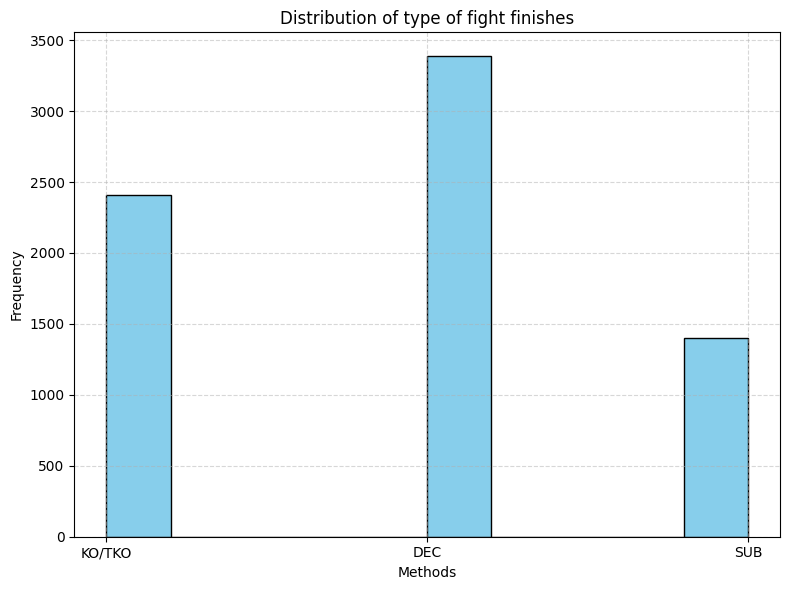

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(df_methods["Method"], color='skyblue', edgecolor='black')
plt.title('Distribution of type of fight finishes')
plt.xlabel('Methods')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let us take a look at "Weight_Class".

In [11]:
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       'Catch Weight', "Women's Featherweight", 'Super Heavyweight',
       'Open Weight'], dtype=object)

Some of these categories are not used in UFC, so we will drop them 

In [12]:
df_fil = weight_destroyer(df_fil)
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       "Women's Featherweight"], dtype=object)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

In [13]:
three, five = df_breaker_by_rounds(df_fil)

df_fil = three.copy()

df_fil

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,"Mobile, Alabama, USA",Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,Middleweight,S-DEC,2.0,3:00,UFC 17,15-May-98,Dan Henderson,480.0
7263,"Mobile, Alabama, USA",David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,Heavyweight,KO/TKO Punches,1.0,0:43,UFC 17,15-May-98,David Abbott,43.0
7264,"Mobile, Alabama, USA",Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,Heavyweight,SUB Keylock,1.0,11:01,UFC 17,15-May-98,Mike van Arsdale,661.0
7265,"Mobile, Alabama, USA",Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,Middleweight,SUB Triangle Choke,1.0,0:52,UFC 17,15-May-98,Carlos Newton,52.0


Now, we are going to remove all unneccassary columns: Date (data doesn't depend on date), Event Name, Round, Time, Location.

In [14]:
df_fil = de_remover(df_fil)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

Finally, our dataframe is ready to be used in project. But before, we will run logit and OLS models, let us create dataframe with fighters statistic.

In [15]:
fighters = list(set(df_fil["Fighter 1"].unique()).union(set(df_fil["Fighter 2"].unique())))
fighters_df = pd.DataFrame({"Fighter_name": [],
                            "Average_significant_strikes": [],
                            "Average_takedowns": [],
                            "Average_submission_attempts": [],
                            "Average_knockdowns": [],
                            "Average_activity": [],
                            "Wins": [],
                            "Loss": [],
                            "Winrate": []})


for ele in fighters:
    win_df = df_fil.loc[df_fil["Fighter 1"] == ele]
    lose_df = df_fil.loc[df_fil["Fighter 2"] == ele]

    wins, losses = int(len(win_df.index)), int(len(lose_df.index))

    amount_of_mentions = wins + losses

    avg_strk = round((win_df["Fighter_1_STR"].sum() + lose_df["Fighter_2_STR"].sum())/amount_of_mentions, 2)
    avg_tkd = round((win_df["Fighter_1_TD"].sum() + lose_df["Fighter_2_TD"].sum())/amount_of_mentions, 2)
    avg_subs = round((win_df["Fighter_1_SUB"].sum() + lose_df["Fighter_2_SUB"].sum())/amount_of_mentions, 2)
    avg_kd = round((win_df["Fighter_1_KD"].sum() + lose_df["Fighter_2_KD"].sum())/amount_of_mentions, 2)
    # weight_class = pd.concat([lose_df["Weight_Class"], win_df["Weight_Class"]])

    avg_act = avg_strk + avg_tkd + avg_subs + avg_kd

    data = {
        "Fighter_name": [ele],
        "Average_significant_strikes": [avg_strk],
        "Average_takedowns": [avg_tkd],
        "Average_submission_attempts": [avg_subs],
        "Average_knockdowns": [avg_kd],
        "Average_activity": [avg_act],
        "Wins": [wins],
        "Loss": [losses],
        "Winrate": [round(wins/(wins+losses), 2)],
        # "Weight_class": [weight_class.unique()]
    }

    fighters_df = pd.concat([fighters_df, pd.DataFrame(data)], ignore_index = True)

fighters_df

,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate
0,Michinori Tanaka,29.60,2.40,0.20,0.00,32.20,2.0,3.0,0.40
1,Vince Cachero,45.50,0.00,0.50,0.00,46.00,0.0,2.0,0.00
2,Yanis Ghemmouri,28.00,0.00,0.00,0.00,28.00,0.0,1.0,0.00
3,Albert Cheng,5.00,0.00,0.00,0.00,5.00,0.0,1.0,0.00
4,John Hathaway,45.56,2.33,0.78,0.22,48.89,7.0,2.0,0.78
...,...,...,...,...,...,...,...,...,...
2308,Joseph Morales,15.00,0.33,1.67,0.33,17.33,1.0,2.0,0.33
2309,Chris Price,5.00,0.00,0.50,0.00,5.50,0.0,2.0,0.00
2310,Sarah Frota,20.50,0.00,0.00,0.00,20.50,0.0,2.0,0.00
2311,Pearl Gonzalez,32.00,1.00,0.50,0.00,33.50,0.0,2.0,0.00


In [16]:
fighters_df = pd.read_csv("./app/data/fighter.csv")

fighters_df = pd.DataFrame(fighters_df)

fighter_weight = fighters_df[fighters_df["Weight_class"].apply(lambda x: "Welterweight" in x)].reset_index(drop=True)

fighter_weight['Fighter_name'].to_list()

['Alexander Yakovlev',
 'Rodrigo de Lima',
 'Sean Spencer',
 'Nathan Coy',
 'Ryan McGillivray',
 'Yancy Medeiros',
 'Mike Rhodes',
 'Shavkat Rakhmonov',
 'Darrius Flowers',
 'Josh Neer',
 'John Howard',
 'Dan Stittgen',
 'Che Mills',
 'Hernani Perpetuo',
 'Sean Brady',
 'Adrian Serrano',
 'John Alessio',
 'Francisco Trinaldo',
 'James Head',
 'Chris Wilson',
 'Tom Breese',
 'Marcio Alexandre Junior',
 'Wendell Oliveira Marques',
 'Jon Manley',
 'Chris Brennan',
 'Stephen Thompson',
 'Bojan Velickovic',
 'Ben Alloway',
 'Matthew Riddle',
 'Ramsey Nijem',
 'Rostem Akman',
 'Rafael Dos Anjos',
 'Zak Ottow',
 'Brandon Thatch',
 'Clay Harvison',
 'Ricardo Almeida',
 'Rich Attonito',
 'Kyle Noke',
 'Lyman Good',
 'Matt Brown',
 'Amir Sadollah',
 'Alex Morono',
 'Joe Stevenson',
 'Khamzat Chimaev',
 'Jonathan Meunier',
 'Kyle Bradley',
 'Paul Bradley',
 'Jake Hecht',
 'Jason Gilliam',
 'Nate Marquardt',
 'Justin Edwards',
 'Kyle Prepolec',
 'Micheal Gillmore',
 'Kamaru Usman',
 'Gil Castillo'

In [17]:
fighters_df

,Unnamed: 0,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate,Weight_class
0,0,Irwin Rivera,50.33,1.00,0.00,0.00,51.33,1.0,2.0,0.33,['Bantamweight' 'Featherweight']
1,1,Nathaniel Wood,69.89,1.67,0.44,0.22,72.22,7.0,2.0,0.78,['Featherweight' 'Bantamweight']
2,2,Ricardo Ramos,29.82,1.73,0.45,0.27,32.27,7.0,4.0,0.64,['Featherweight' 'Bantamweight']
3,3,Mara Romero Borella,23.86,1.14,0.14,0.00,25.14,2.0,5.0,0.29,"[""Women's Flyweight""]"
4,4,Edmen Shahbazyan,27.00,1.22,0.33,0.33,28.88,5.0,4.0,0.56,['Middleweight']
...,...,...,...,...,...,...,...,...,...,...,...
2308,2308,Dan Ige,44.00,0.85,0.08,0.38,45.31,9.0,4.0,0.69,['Featherweight']
2309,2309,Melissa Gatto,50.50,1.00,0.25,0.25,52.00,2.0,2.0,0.50,"[""Women's Flyweight""]"
2310,2310,Kamuela Kirk,35.33,1.00,1.33,0.00,37.66,1.0,2.0,0.33,['Lightweight' 'Featherweight']
2311,2311,Caio Magalhaes,18.43,0.57,0.86,0.29,20.15,4.0,3.0,0.57,['Middleweight']


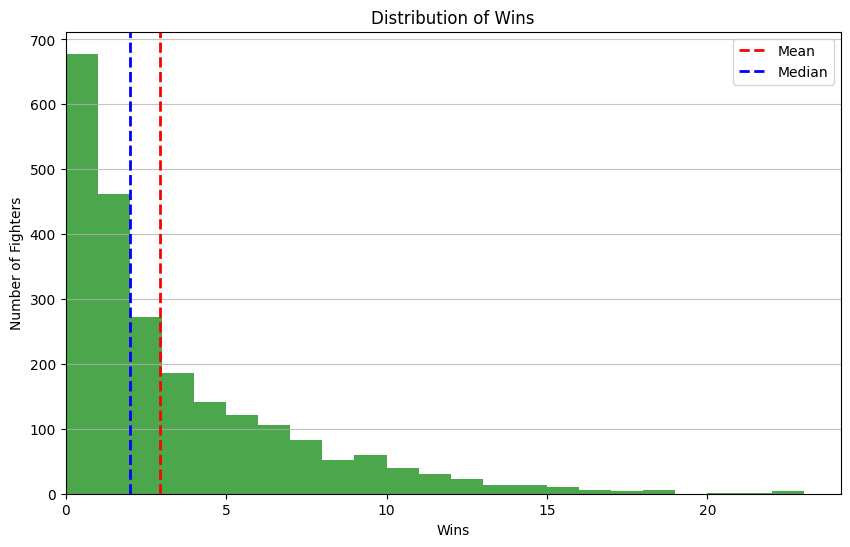

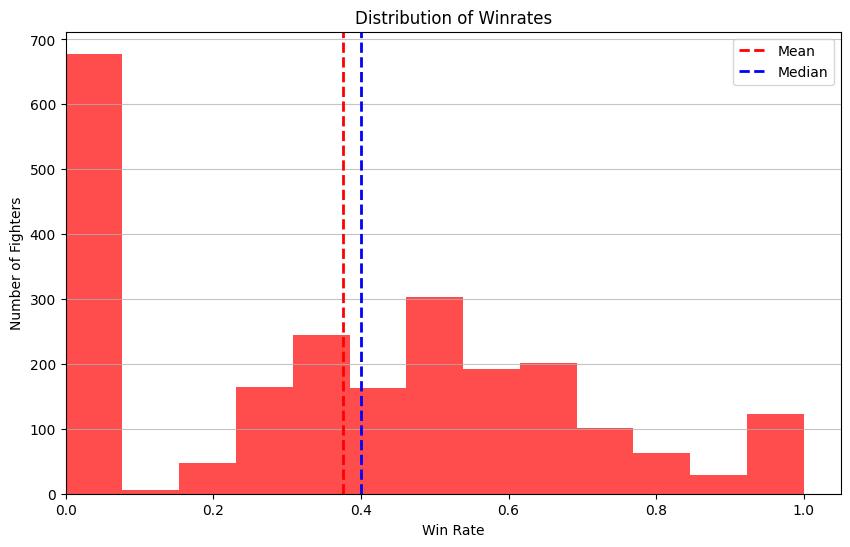

In [18]:
mean_wins = fighters_df["Wins"].mean()
median_wins = fighters_df["Wins"].median()

plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Wins"], bins=int(fighters_df["Wins"].max()), color='green', alpha=0.7)
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wins, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wins, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()

plt.show()

mean_wr = fighters_df["Winrate"].mean()
median_wr = fighters_df["Winrate"].median()
plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Winrate"], bins='auto', color='red', alpha=0.7)
plt.title('Distribution of Winrates')
plt.xlabel('Win Rate')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wr, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wr, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()
plt.show()

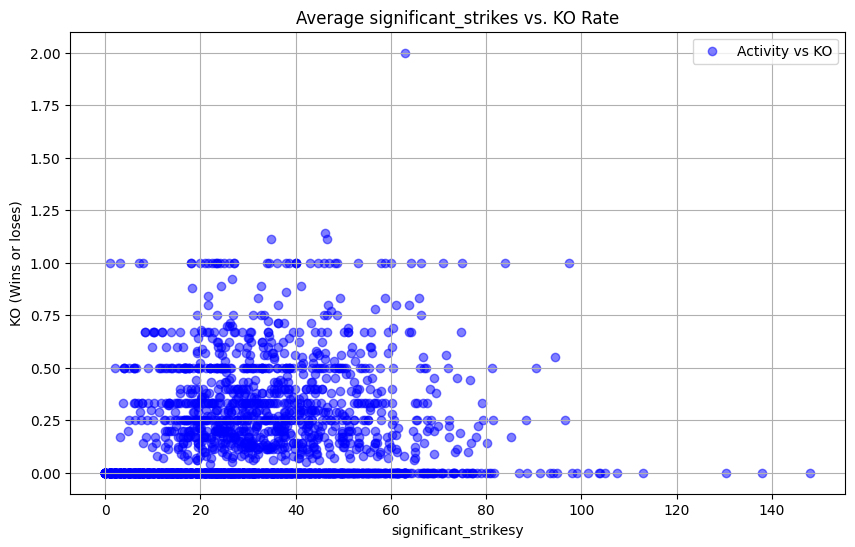

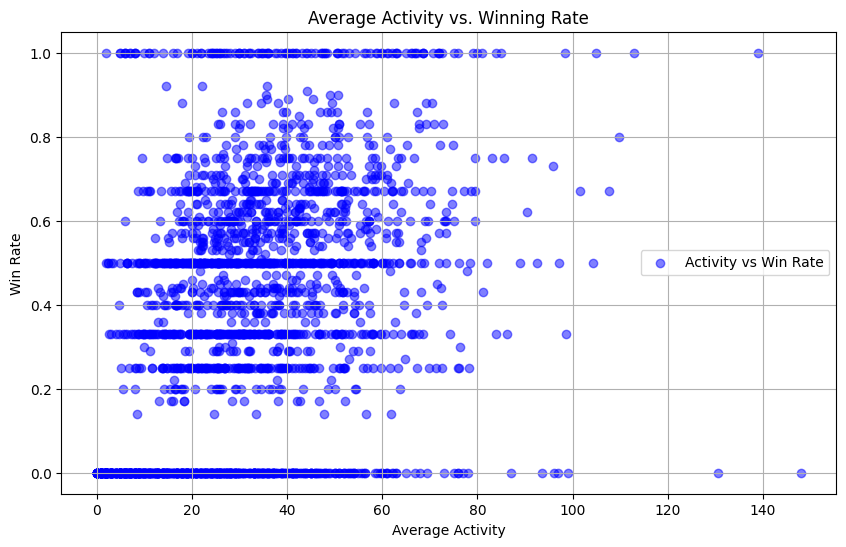

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_significant_strikes"], fighters_df["Average_knockdowns"], color='blue', alpha=0.5, label='Activity vs KO')
plt.title('Average significant_strikes vs. KO Rate')
plt.xlabel('significant_strikesy')
plt.ylabel('KO (Wins or loses)')
plt.legend()
plt.grid(True)
plt.show()

# Improved Scatter plot for Average Activity vs. Win Rate
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_activity"], fighters_df["Winrate"], color='blue', alpha=0.5, label='Activity vs Win Rate')
plt.title('Average Activity vs. Winning Rate')
plt.xlabel('Average Activity')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# cor_df = fighters_df.drop(["Fighter_name"], axis=1)
# correlation_matrix = cor_df.corr()


# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
# plt.title('Correlation Matrix of Fighter Statistics')
# plt.show()

# OLS

Now, we are going to construct OLS method for predicting the duration of fight in seconds. However, our dataframe contains male and female fighters and it is not relevant to predict duration fight in combined dataframe, because man and woman can not have much up in UFC, so we are going to divide dataframe in two: for males and for females

In [21]:
df_fil["Gender"] = np.where(df_fil["Weight_Class"].str.contains("Women"), 1, 0)
df_man = df_fil.loc[df_fil["Gender"] == 0].drop(["Gender"], axis=1).reset_index(drop=True)
df_woman = df_fil.loc[df_fil["Gender"] != 0].drop(["Gender"], axis=1).reset_index(drop=True)

Variables in "Weight_Class" is ordinal, so to make our future OLS more relevent, we need to divide this column to many distinct columns. Each this column will represent the distinct weight category, so if fighters belong to this category we will put 1, if not 0 (It is clear that fighters in one fight can only belongs to one category).

In [22]:
df_man_clear = weight_breaker(df_man)
df_woman_clear = weight_breaker(df_woman)

df_man_clear

,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Winner,Seconds,Lightweight,Bantamweight,Welterweight,Middleweight,Light Heavyweight,Featherweight,Heavyweight,Flyweight
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,Arman Tsarukyan,64.0,1,0,0,0,0,0,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,Jalin Turner,169.0,1,0,0,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,Deiveson Figueiredo,900.0,0,1,0,0,0,0,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,Sean Brady,703.0,0,0,1,0,0,0,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,Joaquim Silva,900.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,Dan Henderson,480.0,0,0,0,1,0,0,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,David Abbott,43.0,0,0,0,0,0,0,1,0
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,Mike van Arsdale,661.0,0,0,0,0,0,0,1,0
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,Carlos Newton,52.0,0,0,0,1,0,0,0,0


In [23]:
winrates_df = history_winrate(df_man_clear)

In [24]:


names = [ele.replace(" ", "_") for ele in winrates_df.columns.to_list()]
winrates_df.columns = names

winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Lightweight,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.88,0.77
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.59
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0.75,0.75
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0.83,0.75
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1.00,1.00
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0.00,0.00


In [25]:
categories_all = [ele for ele in winrates_df.columns if "Fighter" in ele or "winrate" in ele]
categories = [(categories_all[i], categories_all[i+1]) for i in range(0, len(categories_all), 2)]

swapper(winrates_df, categories)



We have lots of zeroes in this dataframe so let us try to remove them or make more meaningful

In [26]:
winrates_df['Winrate_1_is_0'] = np.where(winrates_df["Current_winrate_F1"] == 0, 1, 0)
winrates_df['Winrate_2_is_0'] = np.where(winrates_df["Current_winrate_F2"] == 0, 1, 0)

In [27]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.77,0.88,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# OLS

In [28]:
winrates_df["Seconds"].value_counts()

Seconds
900.0    2686
600.0      39
300.0      20
299.0      20
255.0      15
         ... 
319.0       1
390.0       1
701.0       1
670.0       1
601.0       1
Name: count, Length: 820, dtype: int64

In [29]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_Time=smf.ols(f"Seconds ~ {' + '.join(winrates_df_model)}", data=winrates_df)
print(model_Time.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     581.5
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:13:15   Log-Likelihood:                -41057.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6116   BIC:                         8.229e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            174.9743     15

Now It is seem that weight class in unsignificant variable, so let test their joint significance

In [30]:
weights = winrates_df[['Bantamweight', 'Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight']]

test_model = smf.ols(formula=f"Seconds ~ {' + '.join(weights.columns)}", data=winrates_df).fit()

f_statistic = test_model.fvalue
p_value = test_model.f_pvalue


if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


It seems their are significant. Now let perform model selection with AIC to create the best model

In [31]:
# LASSO SELECTION IS DONE
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(winrates_df_model, winrates_df["Seconds"])
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


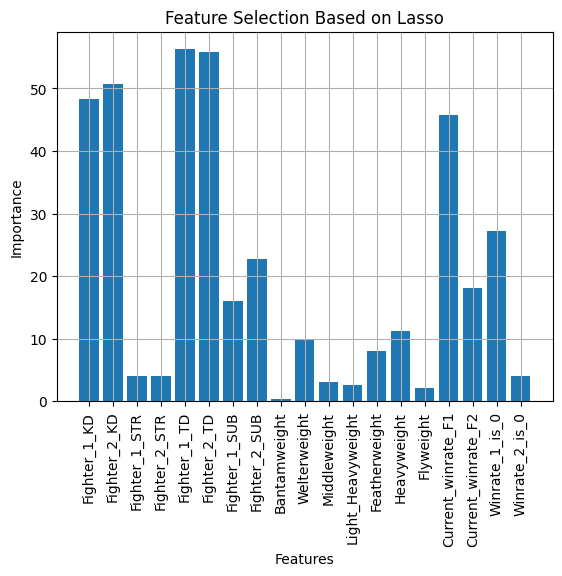

In [32]:

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(winrates_df_model, winrates_df["Seconds"])

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

names = winrates_df_model.columns
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [33]:

selected_model = winrates_df_model[np.array(names)[lasso1_coef>3]]

selected_model

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Welterweight,Middleweight,Featherweight,Heavyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,0,0,0,0,0.77,0.88,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,0,0,0,0,0.59,0.56,0,0
2,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,0,0,0,0,0.75,0.75,0,0
3,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,1,0,0,0,0.75,0.83,0,0
4,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,0,1,0,0,1.00,1.00,0,0
6132,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0,0,0,1,0.00,0.00,1,1
6133,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,0,0,0,1,0.00,0.00,1,1
6134,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0,1,0,0,0.00,0.00,1,1


In [34]:
model_Time_selected=smf.ols(f"Seconds ~ {' + '.join(selected_model)}", data=winrates_df).fit().summary()

model_Time_selected

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     690.8
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:13:17   Log-Likelihood:                -41057.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6119   BIC:                         8.226e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.1225     14.732     11.888      0.000     146.243     204.002
Fighter_1_KD         -48.2612      5.162     -9.349      0.000     -58.381     -38.141
Fighter_2_KD         -50.7810      5.233     -9.704      0.000     -61.040     -40.522
Fighter_1_STR          4.0795      0.119     34.332      0.000       3.847       4.312
Fighter_2_STR          4.0849      0.121     33.724      0.000       3.847       4.322
Fighter_1_TD          56.2645      1.555     36.173      0.000      53.215      59.314
Fighter_2_TD          55.7754      1.649     33.834      0.000      52.544      59.007
Fighter_1_SUB         15.9710      3.088      5.172      0.000       9.918      22.024
Fighter_2_SUB         22.8165      3.014      7.571      0.000      16.908      28.724
Welterweight           9.7024      7.111      1.364      0.172      -4.237      23.642
Middleweight           2.8167      7.699      0.366      0.714     -12.275      17.909
Featherweight         -8.2232      8.652     -0.950      0.342     -25.185       8.739
Heavyweight          -12.7087      7.108     -1.788      0.074     -26.644       1.226
Current_winrate_F1    45.7948     14.174      3.231      0.001      18.009      73.581
Current_winrate_F2    18.1653     14.455      1.257      0.209     -10.172      46.502
Winrate_1_is_0        27.3781     11.210      2.442      0.015       5.403      49.353
Winrate_2_is_0        -3.9661     11.414     -0.347      0.728     -26.342      18.410
==============================================================================
Omnibus:                       43.204   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.237
Skew:                           0.194   Prob(JB):                     4.09e-10
Kurtosis:                       2.861   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us calculate accuracy score for OLS model. To do it, we will need to convert preditions of variable "Second" into ordinal variable "Round" (the same we will need to perform with true values, because column "Round" was dropped at the beginning of research), however accuracy score is bad in distinguish between different classes so we will use f1 score for this purposes

In [35]:
predictor_data = winrates_df_model

predictions = model_Time.fit().predict(predictor_data)

print(predictions)

0       216.224491
1       357.348852
2       819.143707
3       712.176060
4       842.403500
           ...    
6131    639.444295
6132    288.260547
6133    408.241517
6134    309.575993
6135    448.027633
Length: 6136, dtype: float64


In [36]:
accuracy_win = winrates_df.copy()

accuracy_win["Second_Pred"] = predictions
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")

Accuracy: 0.58


In [37]:
winrates_df["Winner"] = pd.to_numeric(winrates_df["Winner"])

In [38]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.77,0.88,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# Logit

In [39]:
winrates_df_model_logit = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=winrates_df)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.333884
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.5181
Time:                        17:13:17   Log-Likelihood:                -2048.7
converged:                       True   LL-Null:                       -4250.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0387      0.237      0.164      0.870      -0.425       0.503
Fight

Let's calculate the accuracy score for logit model

In [40]:
predictor_data_logit = winrates_df_model_logit

predictions_logit = model_logit.fit().predict(predictor_data_logit)

Optimization terminated successfully.
         Current function value: 0.333884
         Iterations 7


Calculate the accuracy score for logit model

In [41]:
predictions_logit = np.where(predictions_logit > 0.5, 1, 0)

tp_and_fp = (winrates_df["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.8720664928292047


In [42]:
metrics.f1_score(winrates_df['Winner'], predictions_logit)

0.8754561320006344

In [43]:
history_avg = winrates_df.copy()

replace_stats_with_avg(history_avg)

history_avg

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.32,0.12,35.09,46.62,1.18,3.38,0.55,0.00,...,0,0,0,0,0,0,0.77,0.88,0,0
1,Bobby Green,Jalin Turner,0.18,0.33,74.73,38.89,0.91,0.33,0.23,0.67,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.67,0.58,24.42,46.25,1.00,0.67,1.67,0.42,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.31,0.17,44.88,52.17,0.94,2.33,0.12,0.67,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Clay Guida,Joaquim Silva,0.18,0.22,31.26,35.44,2.24,0.11,0.47,0.33,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,1.00,0.00,31.00,1.00,1.00,1.00,1.00,3.00,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Joe Pardo,Mike van Arsdale,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0.00,0.00,1,1


Run new logit model for history_avg dataframe

In [44]:
model_logit2=smf.logit(f"Winner ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_logit2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.674080
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                 0.02699
Time:                        17:13:29   Log-Likelihood:                -4136.2
converged:                       True   LL-Null:                       -4250.9
Covariance Type:            nonrobust   LLR p-value:                 4.258e-38
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0671      0.163      0.411      0.681      -0.253       0.387
Fight

In [45]:
model_Time2=smf.ols(f"Seconds ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_Time2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     13.92
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           4.24e-44
Time:                        17:13:29   Log-Likelihood:                -44093.
No. Observations:                6136   AIC:                         8.823e+04
Df Residuals:                    6116   BIC:                         8.836e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            573.3930     25

# Some additional functions to work with dataframe

In [46]:
get_stats_of_fighter(fighters_df, "Arman Tsarukyan")
get_fights_of_fighter(winrates_df, "Arman Tsarukyan")

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.77,0.88,0,0
193,Arman Tsarukyan,Joaquim Silva,0.0,0.0,80.0,23.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.86,0.62,0,0
376,Arman Tsarukyan,Damir Ismagulov,0.0,0.0,34.0,36.0,7.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.83,1.00,0,0
705,Joel Alvarez,Arman Tsarukyan,0.0,0.0,7.0,36.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0.80,0.80,0,0
869,Christos Giagos,Arman Tsarukyan,0.0,1.0,1.0,22.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.50,0.75,0,0
1119,Arman Tsarukyan,Matt Frevola,0.0,0.0,50.0,16.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.75,0,0
1325,Arman Tsarukyan,Davi Ramos,0.0,0.0,91.0,33.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.50,0.67,0,0
1648,Arman Tsarukyan,Olivier Aubin-Mercier,0.0,0.0,47.0,23.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.64,1,0
1755,Islam Makhachev,Arman Tsarukyan,0.0,0.0,14.0,13.0,4.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.83,0.00,0,1


# CHECKING THE ASSUMPTIONS OF BLUE

## To test
 - Linearity
 - Random sampling
 - No perfect collinearity
 - Zero conditional mean
 - Homoskedasticity

## 1. Linearity

In [47]:
winrates_df.columns

Index(['Fighter_1', 'Fighter_2', 'Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_STR', 'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD',
       'Fighter_1_SUB', 'Fighter_2_SUB', 'Method', 'Winner', 'Seconds',
       'Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

In [48]:
winrates_df_for_plot = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

winrates_df_for_plot["Round"] = winrates_df_for_plot["Seconds"].apply(lambda x: math.ceil(x/360))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


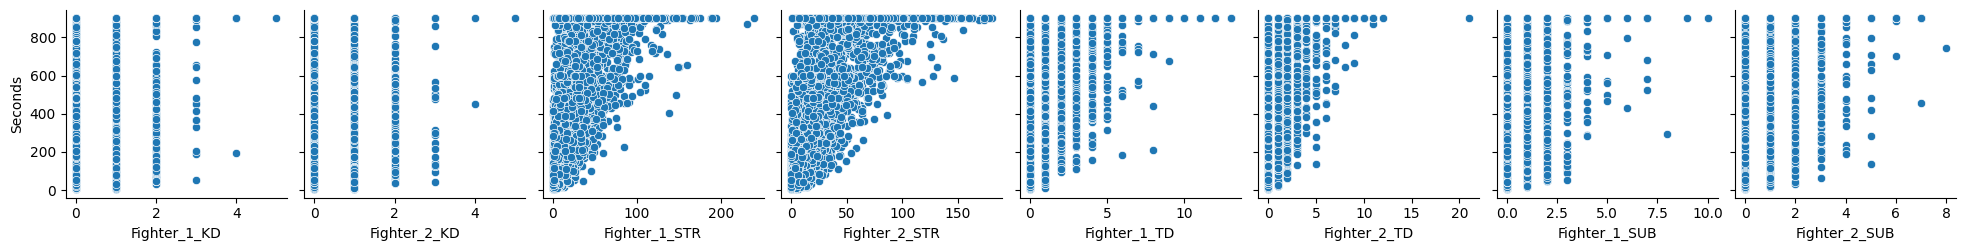

In [49]:
sns.pairplot(winrates_df_for_plot,   x_vars=['Fighter_1_KD', 'Fighter_2_KD','Fighter_1_STR',   'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD','Fighter_1_SUB', 'Fighter_2_SUB'], y_vars="Seconds")

### !!! REMOVE OUTLIERS

## MEAN OF RESIDUALS

In [50]:
predidted_time = model_Time.fit().predict(winrates_df_model)

residuals = winrates_df["Seconds"] - predidted_time

mean_of_residuals = residuals.sum()/residuals.size

mean_of_residuals

-1.892507880090735e-12

OK!

## CHECK FOR HOMOSKEDASTICITY

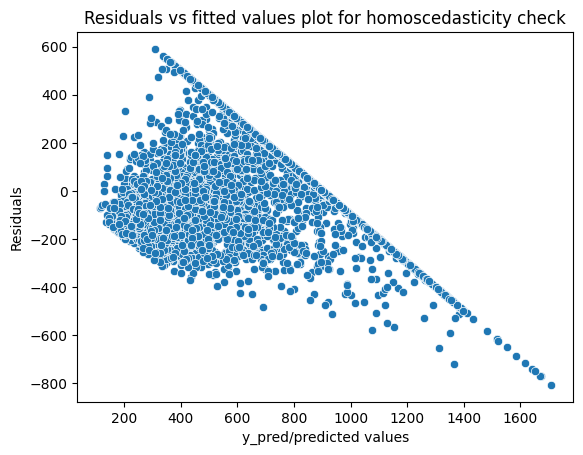

In [51]:

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Null Hypothesis: Error terms are homoscedastic

Alternative Hypothesis: Error terms are heteroscedastic.

In [52]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, winrates_df_model)
lzip(name, test)

[('F statistic', 0.9144231447000291), ('p-value', 0.9932316296337332)]

We can not reject null hypotheses

In [53]:
bartlett(predictions, residuals)

BartlettResult(statistic=528.6836187926078, pvalue=5.46179458054822e-117)

In [54]:
het_white(residuals, model_Time.exog)


(1149.7404220040808,
 3.762738637068663e-142,
 7.761615942136746,
 1.6872831891552456e-161)

## NORMALITY

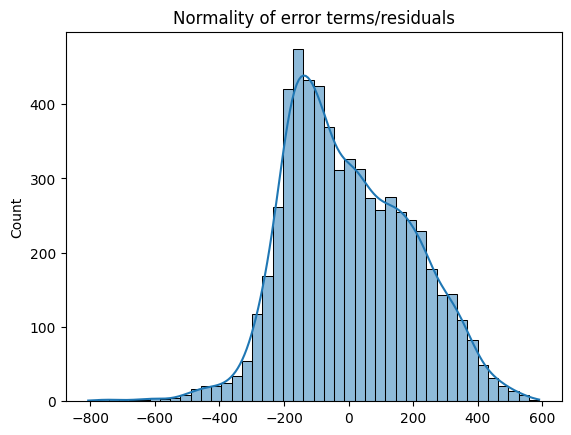

In [55]:
p = sns.histplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

Normal OK

In [56]:
normaltest(residuals)

NormaltestResult(statistic=43.142069314148294, pvalue=4.2836963620439975e-10)

Not normal 

## AUTOCORRELATION

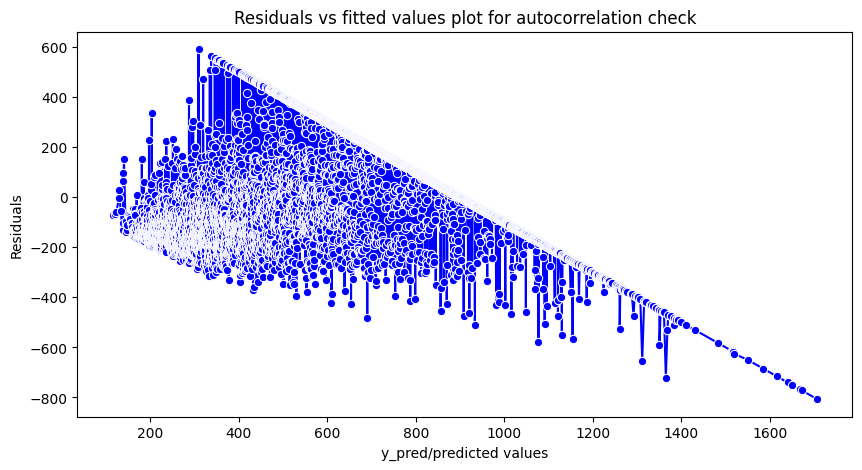

In [57]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y=residuals,x=predidted_time,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

In [58]:
diag.acorr_ljungbox(residuals, lags=12)

,lb_stat,lb_pvalue
1,8.360005,3.835696e-03
2,24.371275,5.103227e-06
3,24.732848,1.755933e-05
4,39.531736,5.409319e-08
5,44.707176,1.663982e-08
6,48.295607,1.031332e-08
7,48.449671,2.907881e-08
8,52.170989,1.559871e-08
9,60.380275,1.132448e-09
10,66.940296,1.721613e-10


Not autocorrelated

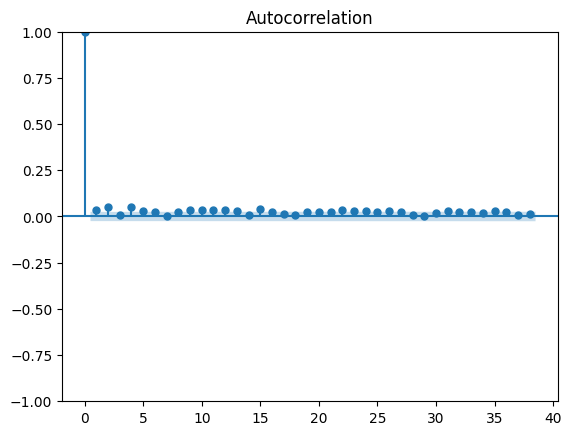

In [59]:
sm.graphics.tsa.plot_acf(residuals)
plt.show()

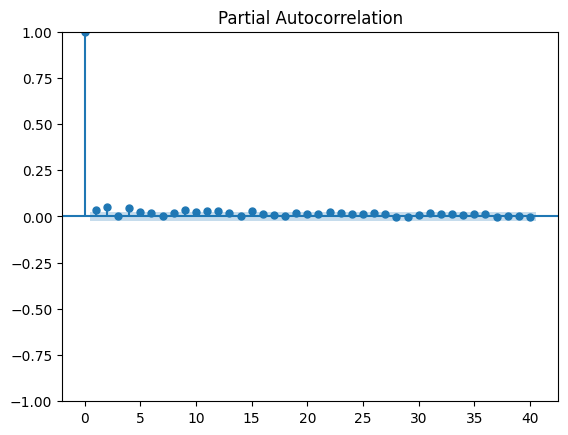

In [60]:
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

## NO PERFECT COLLINEARITY

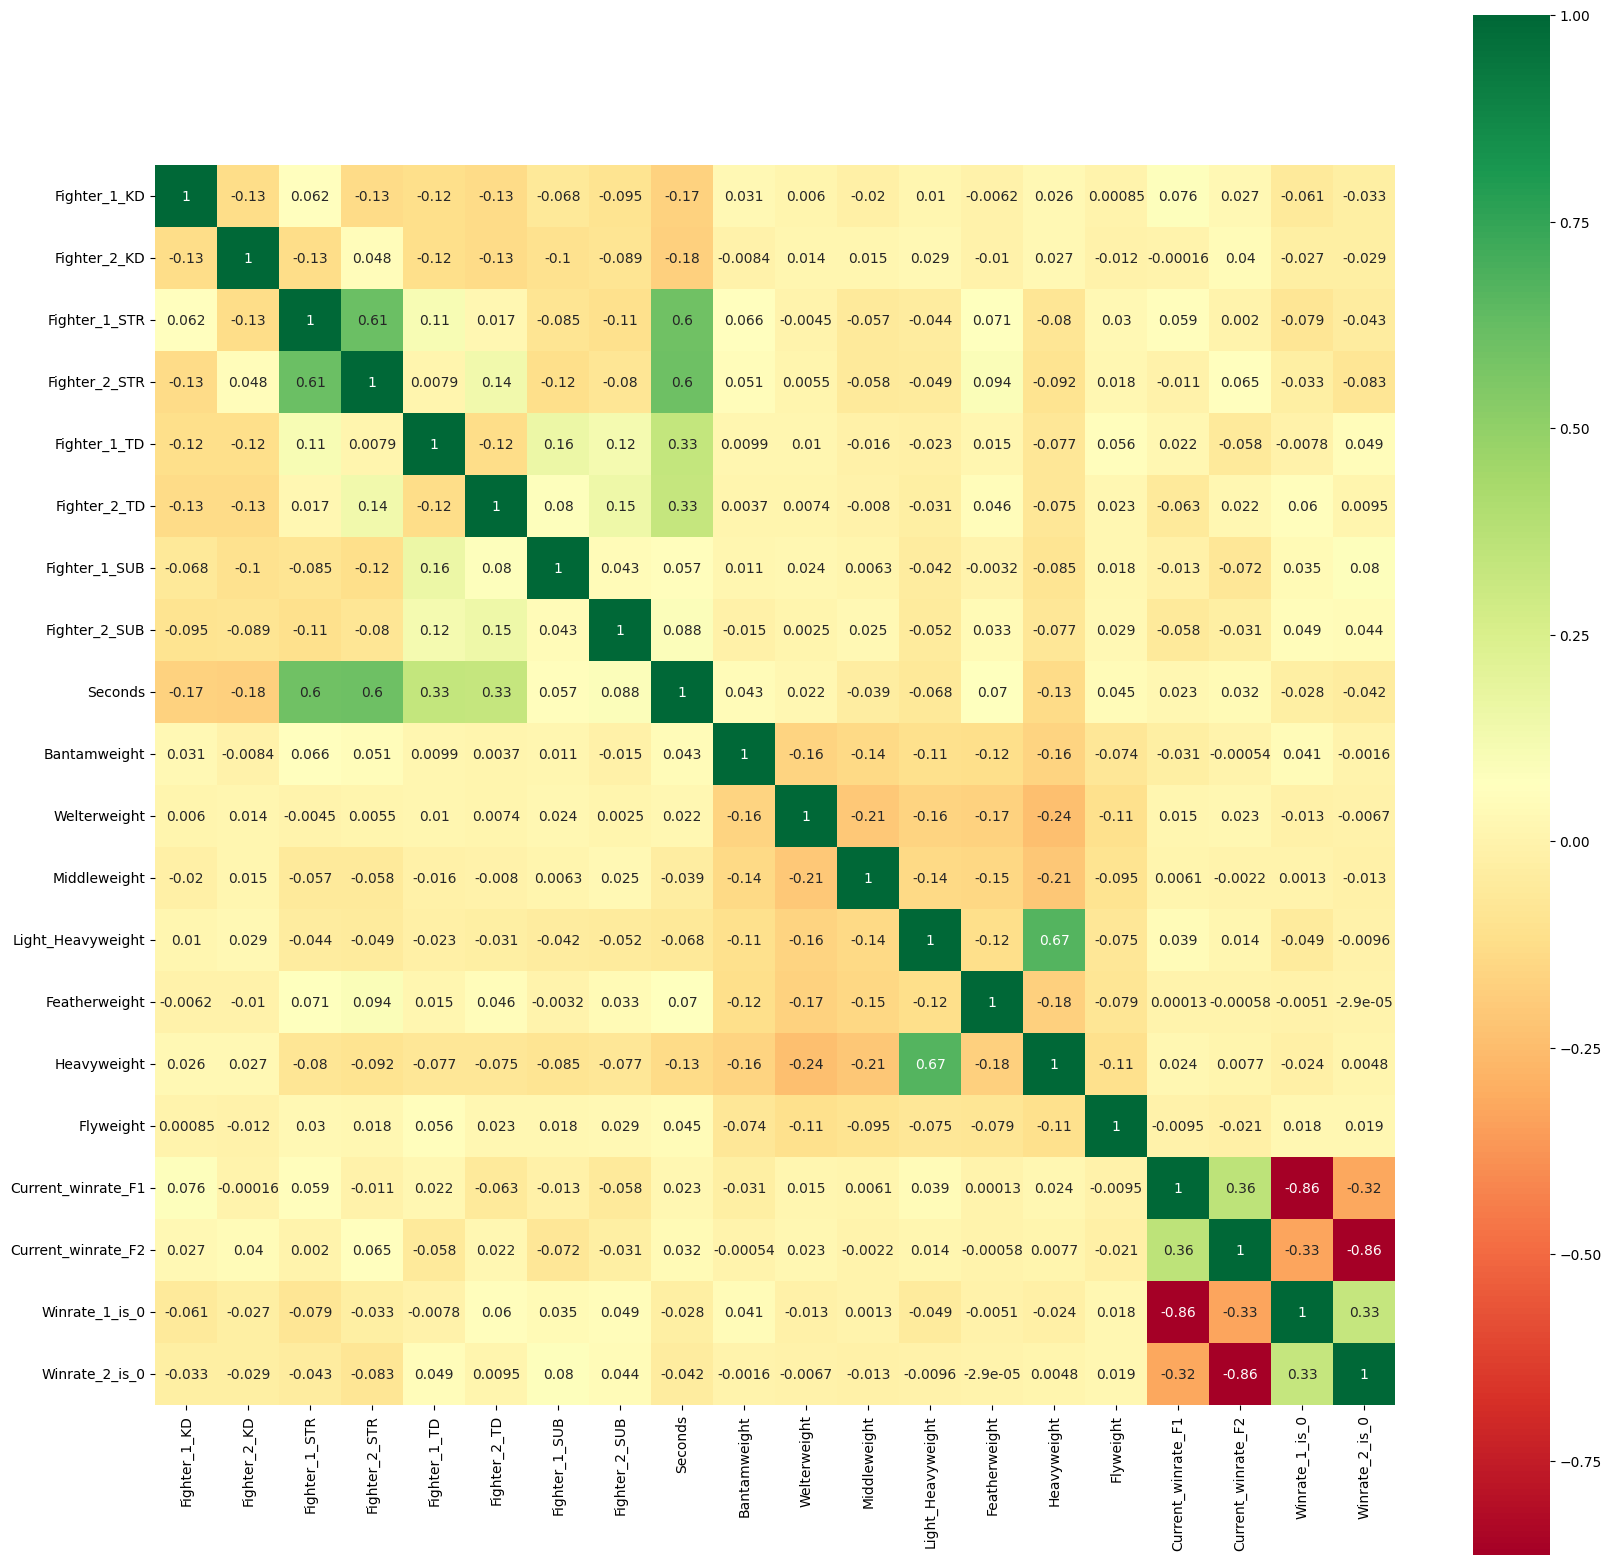

In [61]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

plt.figure(figsize=(20,20)) 
p=sns.heatmap(winrates_df_model.corr(), annot=True,cmap='RdYlGn',square=True)  

OK

## OUTLIERS CLEAN

In [62]:
winrates_df_model.columns

Index(['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB',
       'Seconds', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

<Axes: >

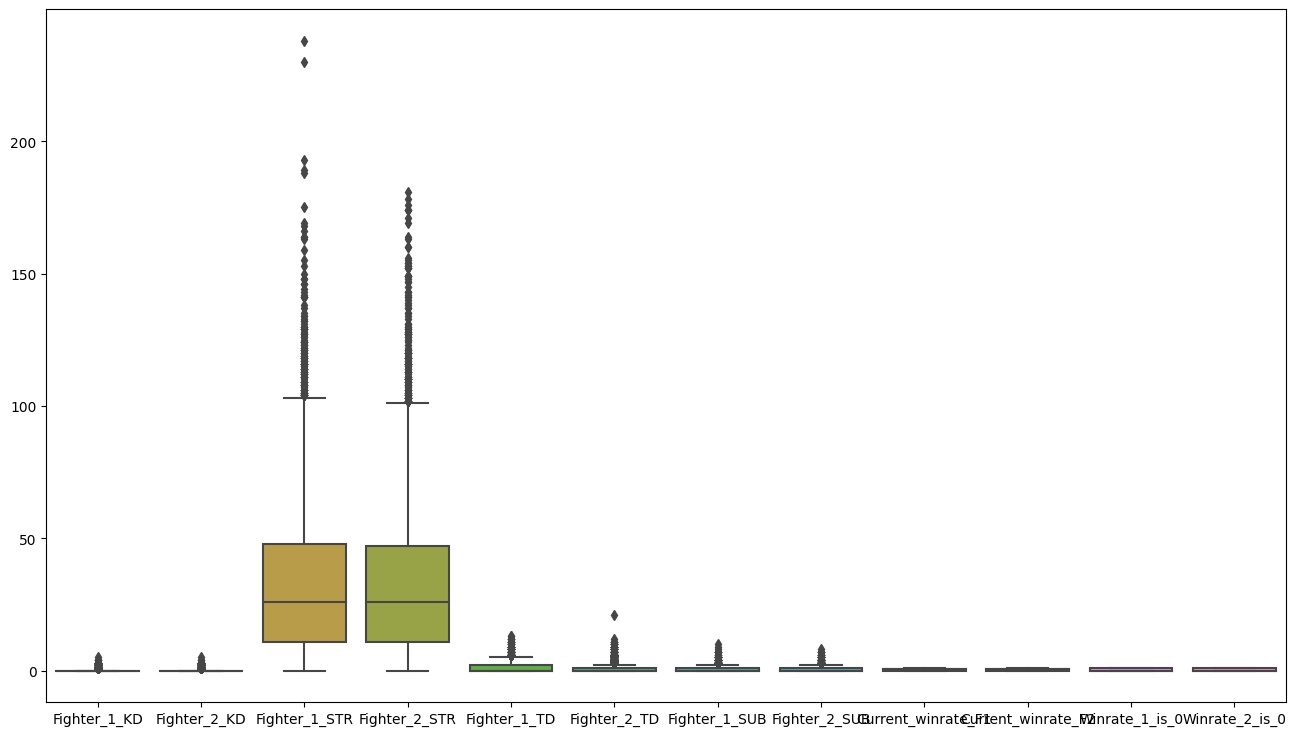

In [63]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

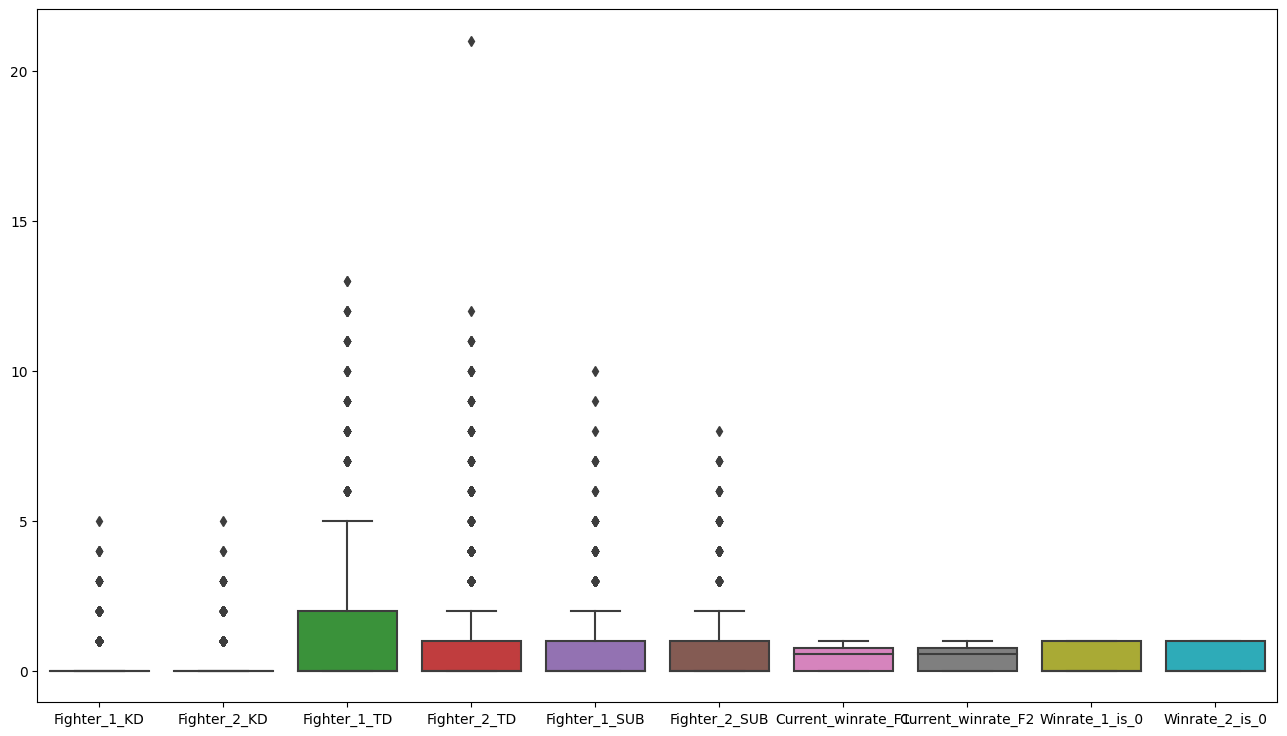

In [64]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

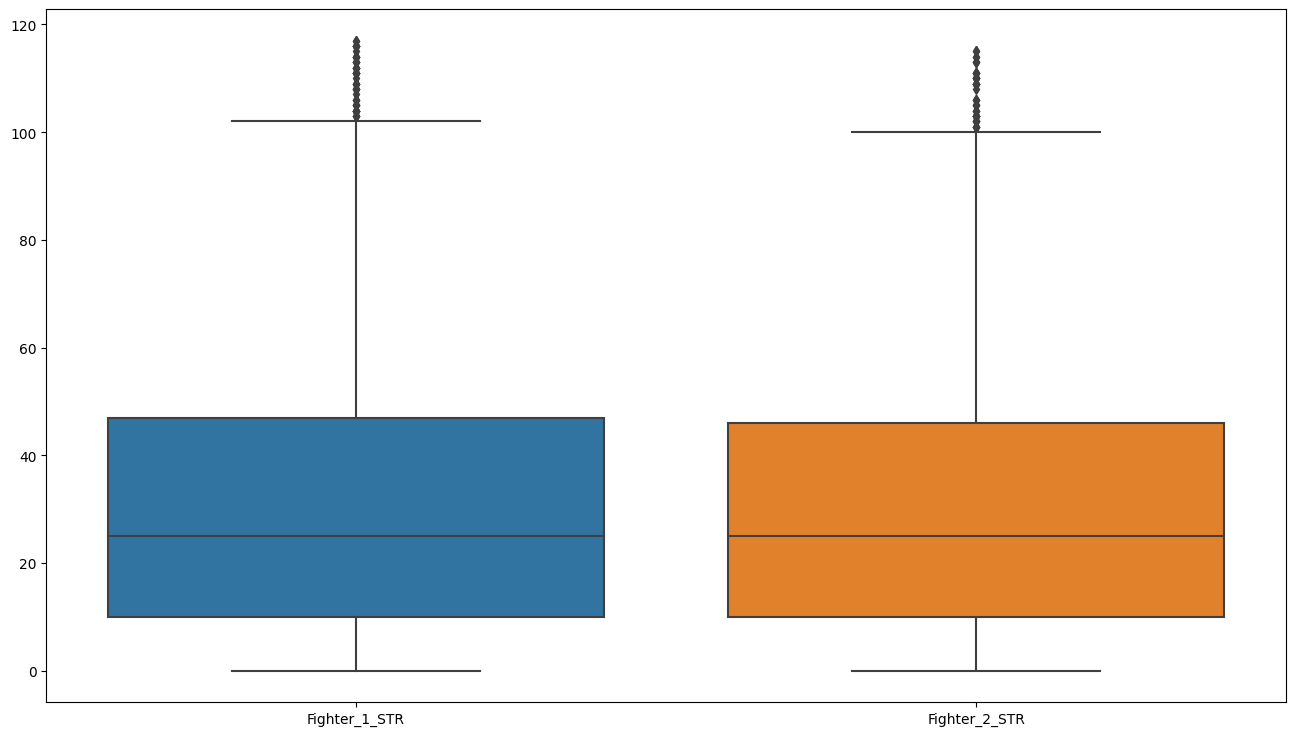

In [65]:
a = winrates_df_model[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)]

plt.figure(figsize=(16,9))
sns.boxplot(a[['Fighter_1_STR', 'Fighter_2_STR']])

In [66]:
outliners_off = a.reset_index(drop=True)

In [67]:
new_m = smf.ols(f"Seconds ~ {' + '.join(outliners_off.drop(['Seconds'], axis=1))}", data=outliners_off).fit()
new_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     610.3
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:13:32   Log-Likelihood:                -33358.
No. Observations:                5034   AIC:                         6.676e+04
Df Residuals:                    5014   BIC:                         6.689e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            144.0453     15.935      9.040      0.000     112.806     175.285
Fighter_1_KD         -73.8591      6.972    -10.594      0.000     -87.526     -60.192
Fighter_2_KD         -73.8359      7.091    -10.412      0.000     -87.738     -59.934
Fighter_1_STR          4.7848      0.134     35.682      0.000       4.522       5.048
Fighter_2_STR          4.9167      0.138     35.562      0.000       4.646       5.188
Fighter_1_TD          64.6685      1.991     32.478      0.000      60.765      68.572
Fighter_2_TD          67.8279      2.272     29.847      0.000      63.373      72.283
Fighter_1_SUB         -0.5694      4.672     -0.122      0.903      -9.728       8.589
Fighter_2_SUB          9.6898      4.693      2.065      0.039       0.490      18.890
Bantamweight          -0.6679     10.202     -0.065      0.948     -20.669      19.333
Welterweight          10.3292      8.314      1.242      0.214      -5.971      26.629
Middleweight           3.8573      8.770      0.440      0.660     -13.336      21.050
Light_Heavyweight     -2.3502     11.269     -0.209      0.835     -24.442      19.742
Featherweight        -23.8793      9.787     -2.440      0.015     -43.066      -4.693
Heavyweight           -6.5062      9.839     -0.661      0.508     -25.795      12.783
Flyweight             -0.2634     13.376     -0.020      0.984     -26.486      25.959
Current_winrate_F1    33.8403     14.799      2.287      0.022       4.829      62.852
Current_winrate_F2    18.3492     14.916      1.230      0.219     -10.892      47.590
Winrate_1_is_0        17.6099     11.676      1.508      0.132      -5.280      40.500
Winrate_2_is_0         0.3790     11.777      0.032      0.974     -22.710      23.468
==============================================================================
Omnibus:                      101.425   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.141
Skew:                           0.352   Prob(JB):                     5.43e-24
Kurtosis:                       3.120   Cond. No.                         474.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

a - norm df

1) Dummy STR remain
2)  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


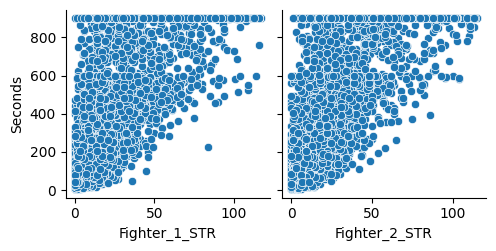

In [68]:
sns.pairplot(outliners_off,   x_vars=['Fighter_1_STR',   'Fighter_2_STR'], y_vars="Seconds")

Remove heteroskedasticity

1) Methode one:

In [69]:
for_fight_str = np.where(a['Fighter_1_STR'] <= 65, 0, 1)
for_second_str = np.where(a['Fighter_2_STR'] <= 65, 0, 1)

df_for_hetero = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

hetero_check_1 = pd.concat([outliners_off, df_for_hetero], axis=1)

In [70]:
hetero_1 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Seconds'], axis=1))}", data=hetero_check_1).fit()
hetero_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     661.4
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:13:32   Log-Likelihood:                -33032.
No. Observations:                5034   AIC:                         6.611e+04
Df Residuals:                    5012   BIC:                         6.625e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             89.5632     15.081      5.939      0.000      59.998     119.129
Fighter_1_KD         -80.9866      6.553    -12.358      0.000     -93.834     -68.139
Fighter_2_KD         -79.3771      6.674    -11.894      0.000     -92.460     -66.294
Fighter_1_STR          6.6316      0.173     38.308      0.000       6.292       6.971
Fighter_2_STR          6.6224      0.174     38.140      0.000       6.282       6.963
Fighter_1_TD          55.5183      1.899     29.233      0.000      51.795      59.242
Fighter_2_TD          59.6039      2.158     27.617      0.000      55.373      63.835
Fighter_1_SUB          5.3089      4.386      1.210      0.226      -3.290      13.908
Fighter_2_SUB         10.4795      4.399      2.382      0.017       1.855      19.104
Bantamweight          -0.6652      9.564     -0.070      0.945     -19.415      18.084
Welterweight          12.2805      7.795      1.576      0.115      -3.000      27.561
Middleweight           4.0842      8.222      0.497      0.619     -12.034      20.203
Light_Heavyweight     -0.3550     10.564     -0.034      0.973     -21.065      20.355
Featherweight        -20.2330      9.176     -2.205      0.027     -38.221      -2.245
Heavyweight           -3.8759      9.224     -0.420      0.674     -21.960      14.208
Flyweight              1.7160     12.539      0.137      0.891     -22.866      26.298
Current_winrate_F1    28.4808     13.874      2.053      0.040       1.281      55.681
Current_winrate_F2    25.7781     13.987      1.843      0.065      -1.642      53.198
Winrate_1_is_0        17.5525     10.945      1.604      0.109      -3.905      39.010
Winrate_2_is_0         8.7404     11.046      0.791      0.429     -12.916      30.396
Fighter_1_Tough     -196.9622     11.323    -17.395      0.000    -219.160    -174.765
Fighter_2_Tough     -198.6495     11.527    -17.233      0.000    -221.248    -176.051
==============================================================================
Omnibus:                      125.479   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.290
Skew:                           0.363   Prob(JB):                     5.67e-31
Kurtosis:                       3.371   Cond. No.                         476.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

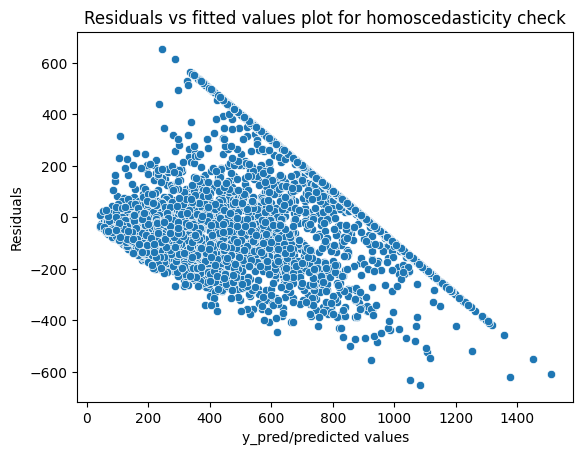

In [71]:
predidted_time = hetero_1.predict(hetero_check_1)

residuals = (hetero_check_1["Seconds"] - predidted_time).dropna()

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

2) Method two

In [124]:
hetero_check_2 = hetero_check_1.copy()

hetero_check_2["Is_Decision"] = np.where(hetero_check_2["Seconds"] == 900, 0, 1)

In [125]:
hetero_2 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_2.drop(['Seconds'], axis=1))}", data=hetero_check_2).fit()
hetero_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1460.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:48:10   Log-Likelihood:                -31332.
No. Observations:                5034   AIC:                         6.271e+04
Df Residuals:                    5011   BIC:                         6.286e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            418.7567     11.755     35.624      0.000     395.712     441.801
Fighter_1_KD         -12.0046      4.779     -2.512      0.012     -21.374      -2.635
Fighter_2_KD         -18.1778      4.842     -3.754      0.000     -27.670      -8.686
Fighter_1_STR          4.2911      0.128     33.522      0.000       4.040       4.542
Fighter_2_STR          4.1500      0.129     32.201      0.000       3.897       4.403
Fighter_1_TD          31.3835      1.399     22.438      0.000      28.641      34.126
Fighter_2_TD          35.8304      1.577     22.717      0.000      32.738      38.923
Fighter_1_SUB         26.0548      3.144      8.288      0.000      19.892      32.218
Fighter_2_SUB         31.8490      3.154     10.099      0.000      25.666      38.032
Bantamweight          -3.0405      6.823     -0.446      0.656     -16.417      10.336
Welterweight           6.9776      5.562      1.255      0.210      -3.925      17.881
Middleweight           9.6379      5.866      1.643      0.100      -1.863      21.138
Light_Heavyweight    -12.5156      7.539     -1.660      0.097     -27.295       2.264
Featherweight        -20.4971      6.546     -3.131      0.002     -33.331      -7.664
Heavyweight           13.6046      6.586      2.066      0.039       0.693      26.516
Flyweight             -9.1819      8.947     -1.026      0.305     -26.722       8.359
Current_winrate_F1    46.0877      9.902      4.655      0.000      26.676      65.499
Current_winrate_F2    25.4857      9.979      2.554      0.011       5.923      45.048
Winrate_1_is_0        30.5337      7.811      3.909      0.000      15.220      45.847
Winrate_2_is_0        12.4486      7.881      1.580      0.114      -3.002      27.899
Fighter_1_Tough     -145.8592      8.111    -17.982      0.000    -161.761    -129.957
Fighter_2_Tough     -141.3943      8.265    -17.108      0.000    -157.597    -125.191
Is_Decision         -345.8115      4.973    -69.540      0.000    -355.560    -336.063
==============================================================================
Omnibus:                      444.775   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              590.524
Skew:                           0.748   Prob(JB):                    5.88e-129
Kurtosis:                       3.761   Cond. No.                         488.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

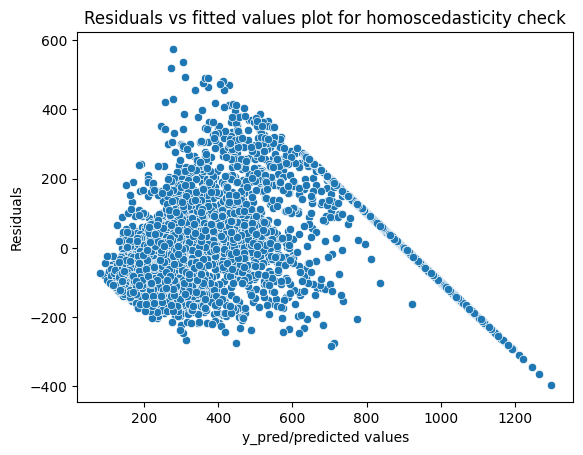

In [126]:
predidted_time = hetero_2.predict(hetero_check_2)

residuals = (hetero_check_2["Seconds"] - predidted_time)

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

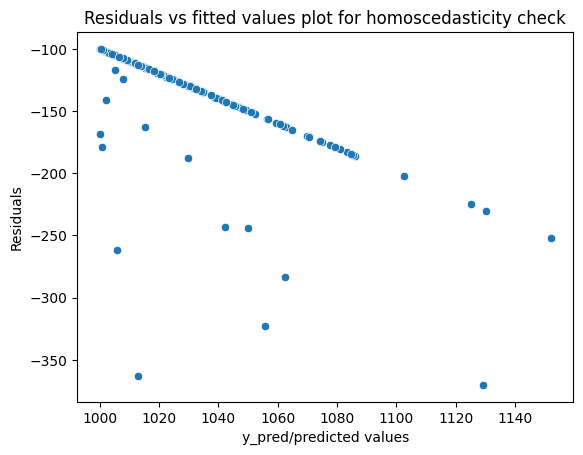

In [120]:
a = predidted_time.loc[predidted_time > 1000]
i = a.index

b = residuals.iloc[i]


p = sns.scatterplot(x=a, y=b)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

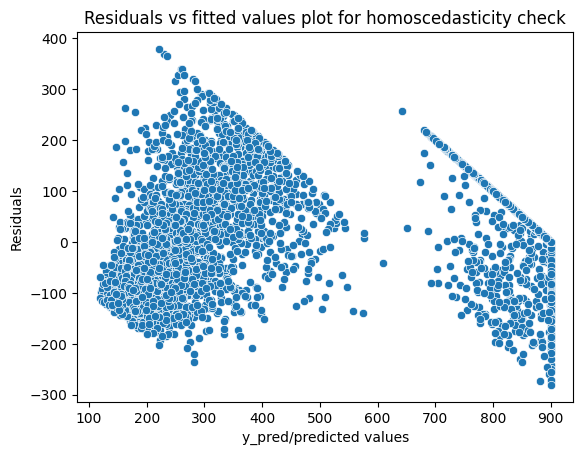

In [121]:
test = np.where(predidted_time > 900, 900, predidted_time)

res_test = hetero_check_2["Seconds"] - test


p = sns.scatterplot(x=test, y=res_test)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

AHUET

now let us try to perform model selection

In [78]:
hetero_check_2

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Seconds,Bantamweight,...,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0,Fighter_1_Tough,Fighter_2_Tough,Is_Decision
0,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,64.0,0,...,0,0,0,0.77,0.88,0,0,0,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,169.0,0,...,0,0,0,0.59,0.56,0,0,0,0,0
2,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,900.0,1,...,0,0,0,0.75,0.75,0,0,0,0,1
3,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,900.0,0,...,0,0,0,0.53,0.56,0,0,0,0,1
4,0.0,1.0,31.0,64.0,0.0,4.0,0.0,1.0,550.0,0,...,0,0,0,0.50,0.20,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,0.0,0.0,31.0,11.0,4.0,2.0,0.0,0.0,540.0,0,...,0,0,0,0.00,0.00,1,1,0,0,0
5030,0.0,1.0,26.0,22.0,3.0,0.0,0.0,1.0,338.0,0,...,0,1,0,0.00,0.00,1,1,0,0,0
5031,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,43.0,0,...,0,1,0,0.00,0.00,1,1,0,0,0
5032,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,661.0,0,...,0,1,0,0.00,0.00,1,1,0,0,0


In [123]:
hetero_21 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_2.drop(['Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight', 'Seconds'], axis=1))}", data=hetero_check_2).fit()
hetero_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     3395.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:42:39   Log-Likelihood:                -30304.
No. Observations:                5034   AIC:                         6.064e+04
Df Residuals:                    5018   BIC:                         6.074e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            125.7497      8.326     15.104      0.000     109.428     142.071
Fighter_1_KD         -30.1312      3.841     -7.845      0.000     -37.660     -22.602
Fighter_2_KD         -25.9484      3.915     -6.628      0.000     -33.624     -18.273
Fighter_1_STR          3.1775      0.106     29.887      0.000       2.969       3.386
Fighter_2_STR          2.9714      0.107     27.719      0.000       2.761       3.182
Fighter_1_TD          21.3271      1.153     18.504      0.000      19.068      23.587
Fighter_2_TD          24.0867      1.302     18.501      0.000      21.534      26.639
Fighter_1_SUB         13.6814      2.543      5.381      0.000       8.697      18.666
Fighter_2_SUB         18.9076      2.552      7.408      0.000      13.904      23.912
Current_winrate_F1    20.2136      8.060      2.508      0.012       4.412      36.015
Current_winrate_F2    19.3682      8.120      2.385      0.017       3.449      35.287
Winrate_1_is_0        10.3388      6.353      1.627      0.104      -2.116      22.794
Winrate_2_is_0        10.8788      6.413      1.696      0.090      -1.694      23.451
Fighter_1_Tough     -122.2006      6.622    -18.453      0.000    -135.183    -109.218
Fighter_2_Tough     -116.1961      6.751    -17.212      0.000    -129.431    -102.962
Is_Decision          432.8507      4.360     99.269      0.000     424.302     441.399
==============================================================================
Omnibus:                       73.764   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.817
Skew:                           0.303   Prob(JB):                     2.09e-17
Kurtosis:                       2.994   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

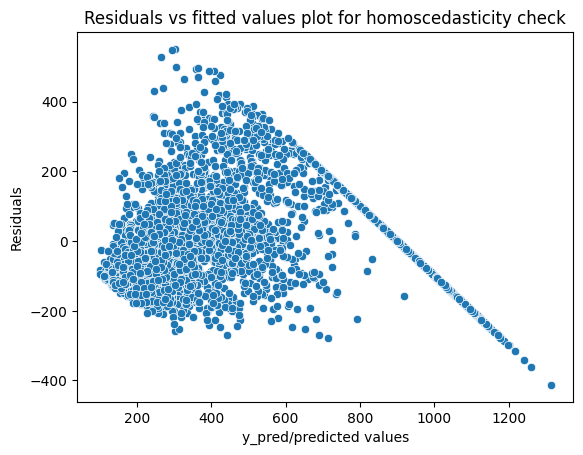

In [80]:
predidted_time = hetero_21.predict(hetero_check_2.drop(["Seconds"], axis=1))

residuals = (hetero_check_2["Seconds"] - predidted_time).dropna()

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Logit improved

## Logit model updated

In [94]:
def improve_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Improve the dataframe ability to construct good OLS models
    """
    outlieners_off = df[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)].reset_index(drop=True)
    
    for_fight_str = np.where(outlieners_off['Fighter_1_STR'] <= 65, 0, 1)
    for_second_str = np.where(outlieners_off['Fighter_2_STR'] <= 65, 0, 1)

    df_for_tough = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

    tough_df = pd.concat([outlieners_off, df_for_tough], axis=1)
    tough_df["Is_Decision"] = np.where(tough_df["Seconds"] == 900, 1, 0)

    result = tough_df.drop(['Lightweight','Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight'], axis=1).reset_index(drop=True)

    return result
        

In [95]:
test = improve_df(winrates_df)
test

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Method,Winner,Seconds,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0,Fighter_1_Tough,Fighter_2_Tough,Is_Decision
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,KO/TKO Punch,0,64.0,0.77,0.88,0,0,0,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,KO/TKO Punches,0,169.0,0.59,0.56,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,U-DEC,1,900.0,0.75,0.75,0,0,0,0,1
3,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,U-DEC,0,900.0,0.53,0.56,0,0,0,0,1
4,Punahele Soriano,Dustin Stoltzfus,0.0,1.0,31.0,64.0,0.0,4.0,0.0,1.0,SUB Rear Naked Choke,0,550.0,0.50,0.20,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,Tulio Palhares,Adriano Santos,0.0,0.0,31.0,11.0,4.0,2.0,0.0,0.0,KO/TKO Punches,1,540.0,0.00,0.00,1,1,0,0,0
5030,Mark Coleman,Pete Williams,0.0,1.0,26.0,22.0,3.0,0.0,0.0,1.0,KO/TKO Kick,0,338.0,0.00,0.00,1,1,0,0,0
5031,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,KO/TKO Punches,0,43.0,0.00,0.00,1,1,0,0,0
5032,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,SUB Keylock,0,661.0,0.00,0.00,1,1,0,0,0


In [100]:
winrates_df_model_logit = test.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=test)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.322832
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 5034
Model:                          Logit   Df Residuals:                     5017
Method:                           MLE   Df Model:                           16
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.5340
Time:                        17:27:34   Log-Likelihood:                -1625.1
converged:                       True   LL-Null:                       -3487.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0707      0.260      0.271      0.786      -0.440       0.581
Fight